Our goal was to demonstrate how Echo State Networks can be used for prediction of dynamical systems behaviour and to compare it to other methods not connected with Reservoir computing.
There is not much software available for ESNs. We decided to use EchoTorch: https://github.com/nschaetti/EchoTorch which is ESN library integrated with PyTorch.

Note: When installing don't use pip install echotorch. Instead call 'pip install git+https://github.com/nschaetti/EchoTorch'

In [20]:
import echotorch as echo
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


Let's start with Mackey-Glass problem with dataset generated as in https://iopscience.iop.org/article/10.1088/1742-6596/720/1/012002/pdf


In [2]:

import torch
from torch.utils.data.dataset import Dataset
import collections

class MackeyGlassDataset2(Dataset):
    def __init__(self, sample_len, n_samples,tau=17,delta=6,x0=1.2,alpha=0.2,beta=0.1,delay=1, seed=None):
        self.sample_len = sample_len
        self.n_samples = n_samples
        self.tau = tau
        self.delta = delta
        self.x0 = x0
        self.alpha=alpha
        self.beta=beta
        self.past = [self.x0] * (self.delta * self.tau)
        self.delay=delay

        if seed is not None:
            torch.manual_seed(seed)

    def __len__(self): # 1 for our use case
        return self.n_samples

    def __getitem__(self, idx):
        series = torch.zeros(self.sample_len+self.delay, 1)

        for timestep in range(self.sample_len+self.delay):
            for _ in range(self.delta):
                x_tau = self.past.pop(0)
                x_t = self.past[-1]
                x_t1 = x_t + (((self.alpha * x_tau) / (1 + x_tau**10))-self.beta * x_t)
                self.past.append(x_t1)
                
            series[timestep] = self.past[-1]
        
        inputs = torch.tan(series-1)

        # Squash timeseries through tanh
        return inputs[:-self.delay], inputs[self.delay:]

In [55]:
import random

def random_grid_search(train_data,test_data,hidden_range,radius_range,leaky_range,num_samples):
    train_inputs,train_targets = train_data
    test_inputs,test_targets = test_data
    
    hidden = np.random.randint(hidden_range[0],hidden_range[1],size=num_samples,dtype=np.int32)
    radius = np.random.rand(num_samples)*(radius_range[1] -radius_range[0]) + radius_range[0]
    leaky = np.random.rand(num_samples)*(leaky_range[1] -leaky_range[0])+leaky_range[0]
    
    min_mse=None
    min_rmse=Nonea
    min_hidden,min_radius,min_leaky=None,None,None
    mses = []
    
    for hid,rad,leak in zip(hidden,radius,leaky):
        esn = etnn.LiESN(
            input_dim=1,
            hidden_dim=int(hid),
            output_dim=1,
            spectral_radius=rad,
            learning_algo='inv',
            leaky_rate=leak
        )
        esn(train_inputs, train_targets)
        esn.finalize()
        y_predicted = esn(test_inputs)
        mse = echotorch.utils.mse(y_predicted.data, test_targets.data)
        rmse = echotorch.utils.rmse(y_predicted.data, test_targets.data)
        if not min_mse or mse < min_mse:
            min_mse,min_rmse,min_hidden,min_radius,min_leaky=mse,rmse,hid,rad,leak
        mses.append(mse)
    
    return min_mse,min_rmse,min_hidden,min_radius,min_leaky,mses
        
        
    


min_mse: 0.000903455016668886; min_rmse: 0.030057528452434108
 for hid=100, rad=1.149010050676563,leak=0.8106425416693215


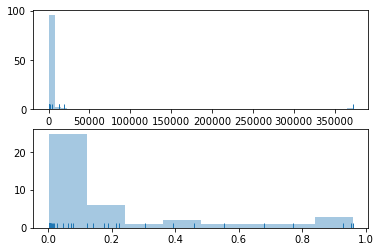

min_mse: 0.0009352233610115945; min_rmse: 0.03058142182782865
 for hid=101, rad=1.2574014064706134,leak=0.8574489719981251


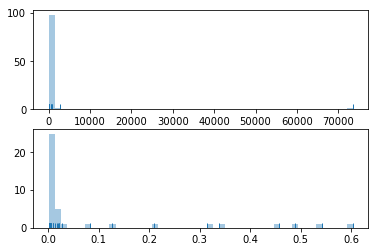

min_mse: 0.0014758993638679385; min_rmse: 0.03841743567532766
 for hid=157, rad=1.2657420621832698,leak=0.8618848603365739


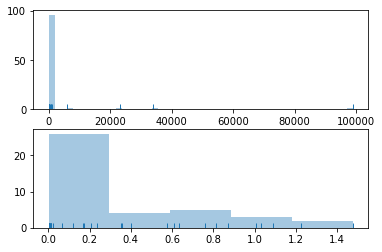

min_mse: 0.0009274753392674029; min_rmse: 0.03045447978980109
 for hid=116, rad=1.1992915915626199,leak=0.8385467357438607


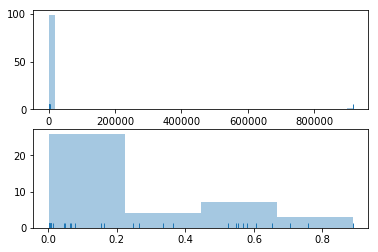

min_mse: 0.0009866775944828987; min_rmse: 0.03141142458537815
 for hid=165, rad=1.1586973611552542,leak=0.8505391151314667


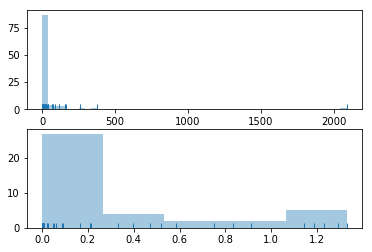

min_mse: 0.001081791240721941; min_rmse: 0.03289059501927475
 for hid=119, rad=1.2699726576547223,leak=0.8970405795148659


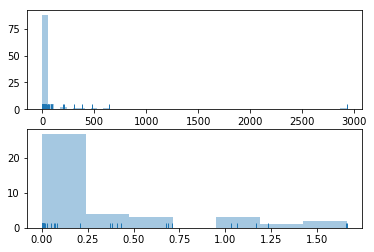

min_mse: 0.0009590970003046095; min_rmse: 0.030969291246404226
 for hid=163, rad=1.2650854267382154,leak=0.9418492390166692


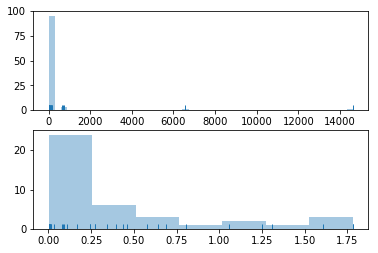

min_mse: 0.000981811317615211; min_rmse: 0.03133386853893421
 for hid=120, rad=1.1169882046061443,leak=0.898397424456894


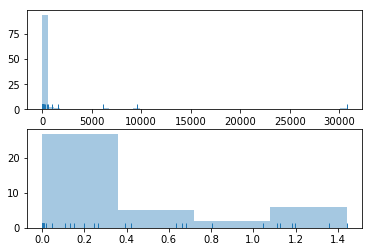

min_mse: 0.000829743396025151; min_rmse: 0.028805266810518367
 for hid=104, rad=1.2966054941449132,leak=0.8672126031266925


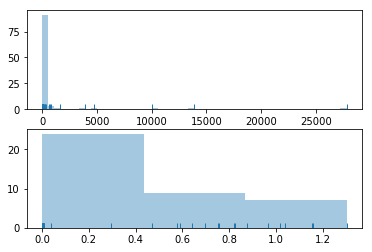

min_mse: 0.0009045592159964144; min_rmse: 0.030075890942687207
 for hid=169, rad=1.1589343420055478,leak=0.9373390734155812


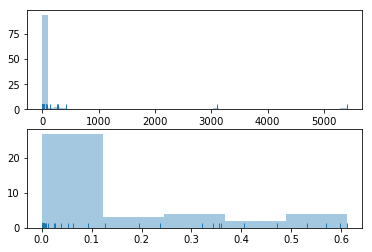

In [70]:

from echotorch.datasets.MackeyGlassDataset import MackeyGlassDataset
import echotorch.nn as etnn
import echotorch.utils
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader

# Dataset params
train_sample_length = 1000
n_train_samples = 2

for i in range(10):
    train = MackeyGlassDataset2(train_sample_length, n_train_samples, tau=17,delta=1,delay=6)
    trainloader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)
    trainiter = iter(trainloader)
    min_mse,min_rmse,min_hidden,min_radius,min_leaky,mses = random_grid_search(
        trainiter.next(),
        trainiter.next(),
        hidden_range=[80,200],
        radius_range=[0.8,1.3],
        leaky_range=[0.5,0.99],
        num_samples=100
        )
    print(f'min_mse: {min_mse}; min_rmse: {min_rmse}\n for hid={min_hidden}, rad={min_radius},leak={min_leaky}')
    fig, axs = plt.subplots(2)
    sns.distplot(mses,rug=True,kde=False,ax = axs[0])

    sns.distplot(sorted(mses)[:40],rug=True,kde=False,ax = axs[1])
    
    plt.show()

Test MSE: 0.0008326942916028202
Test RMSE: 0.028856442809237944


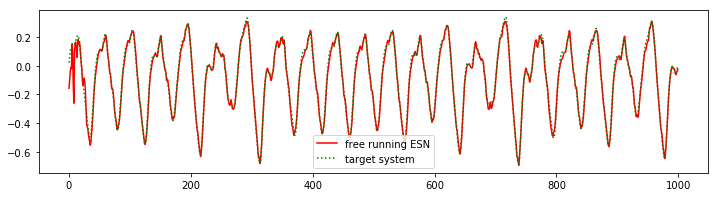

In [110]:

train = MackeyGlassDataset2(train_sample_length, n_train_samples, tau=17,delta=1,delay=6)
trainloader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)
esn = etnn.LiESN(
    input_dim=1,
    hidden_dim=104,
    output_dim=1,
    spectral_radius=1.2966,
    learning_algo='inv',
    leaky_rate=0.867
)


dataiter = iter(trainloader)
data = dataiter.next()
#train
inputs, targets = data
esn(inputs, targets)
esn.finalize()

test_u, test_y = dataiter.next()
y_predicted = esn(test_u)
print(u"Test MSE: {}".format(echotorch.utils.mse(y_predicted.data, test_y.data)))
print(u"Test RMSE: {}".format(echotorch.utils.rmse(y_predicted.data, test_y.data)))

plt.figure(figsize=(12,3))
plt.plot(range(train_sample_length),list(y_predicted.data.reshape((-1,))[0:]),'r-', label="free running ESN")
plt.plot(range(train_sample_length),list(test_y.data.reshape((-1,))[0:]),'g:',label="target system")
plt.legend()
plt.show()

Let's compare to results shown in:https://iopscience.iop.org/article/10.1088/1742-6596/720/1/012002/pdf

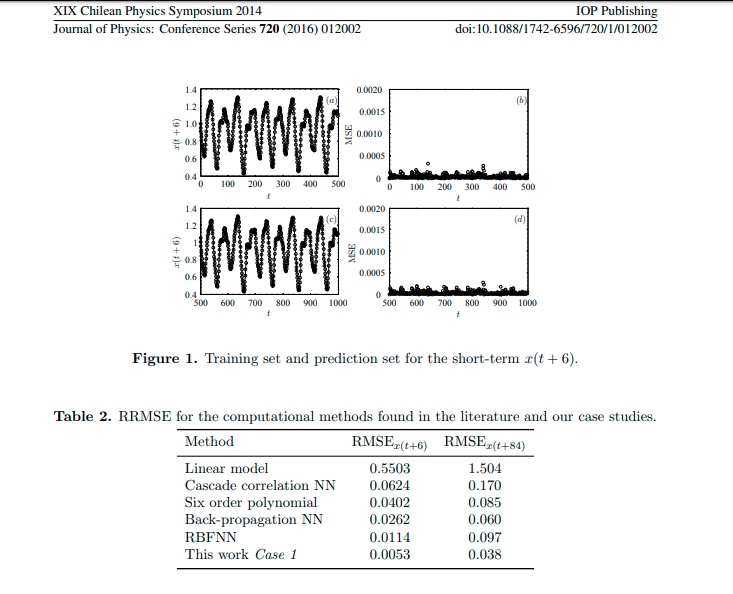


We can see that simple Echo State Network with some parameter tuning can estimate MackeyGlass 6 steps ahead on level comparable to "Back-propagation NN" but not at good as shown in this paper
Moreover ESN are randomly initialized. They are fast but sometimes unstable what can be seen on histograms above

In [115]:
import random

def random_grid_search_stacked(train_data,test_data,hidden_range,radius_range,leaky_range,num_samples):
    train_inputs,train_targets = train_data
    test_inputs,test_targets = test_data
    
    hidden = np.random.randint(hidden_range[0],hidden_range[1],size=num_samples,dtype=np.int32)
    radius = np.random.rand(num_samples)*(radius_range[1] -radius_range[0]) + radius_range[0]
    leaky = np.random.rand(num_samples)*(leaky_range[1] -leaky_range[0])+leaky_range[0]
    
    min_mse=None
    min_rmse=None
    min_hidden,min_radius,min_leaky=None,None,None
    mses = []
    
    for hid,rad,leak in zip(hidden,radius,leaky):
        esn = etnn.StackedESN(
            input_dim=1,
            hidden_dim=[int(hid),int(hid),int(hid)],
            output_dim=1,
            spectral_radius=rad,
            learning_algo='inv',
            leaky_rate=[leak,leak,leak]
        )
        esn(train_inputs, train_targets)
        esn.finalize()
        y_predicted = esn(test_inputs)
        mse = echotorch.utils.mse(y_predicted.data, test_targets.data)
        rmse = echotorch.utils.rmse(y_predicted.data, test_targets.data)
        if not min_mse or mse < min_mse:
            min_mse,min_rmse,min_hidden,min_radius,min_leaky=mse,rmse,hid,rad,leak
        mses.append(mse)
    
    return min_mse,min_rmse,min_hidden,min_radius,min_leaky,mses
        
        
    


min_mse: 0.0006733363261446357; min_rmse: 0.025948724942560005
 for hid=117, rad=1.1406160607390674,leak=0.935737586535313


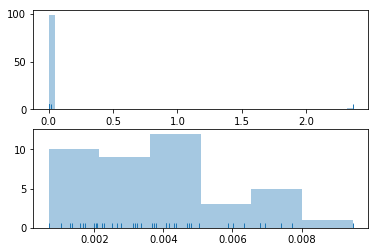

min_mse: 0.0007367921061813831; min_rmse: 0.027143914717324455
 for hid=154, rad=1.2191244842290843,leak=0.9318399742361781


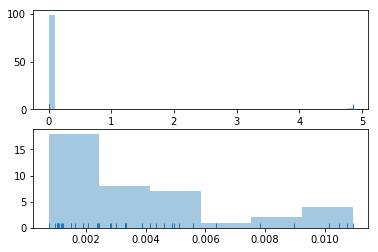

min_mse: 0.0008506496669724584; min_rmse: 0.029165899042759822
 for hid=107, rad=1.1130244500669384,leak=0.8364914560844742


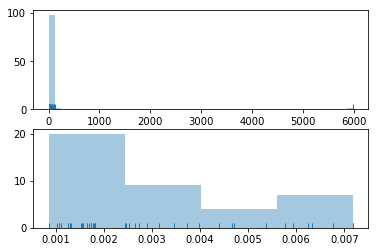

min_mse: 0.0007142603863030672; min_rmse: 0.026725650343875026
 for hid=152, rad=1.433287704521471,leak=0.8390977546051


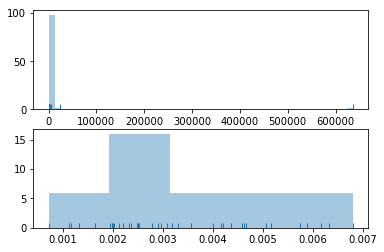

min_mse: 0.000800746027380228; min_rmse: 0.028297456199811107
 for hid=118, rad=1.2919193280699857,leak=0.8086789157753643


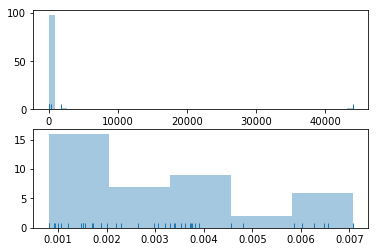

min_mse: 0.0007256115786731243; min_rmse: 0.026937178372523064
 for hid=142, rad=1.2234565412977878,leak=0.900231349096531


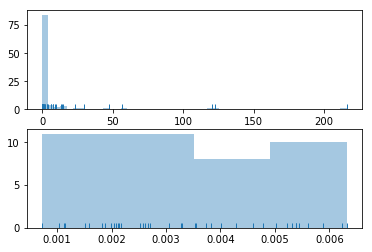

min_mse: 0.0007902839570306242; min_rmse: 0.02811198956016141
 for hid=121, rad=1.3047753996830025,leak=0.8645464902525382


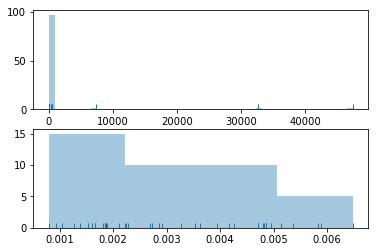

min_mse: 0.001050987048074603; min_rmse: 0.03241893039683146
 for hid=132, rad=1.244163988193477,leak=0.9161783234590571


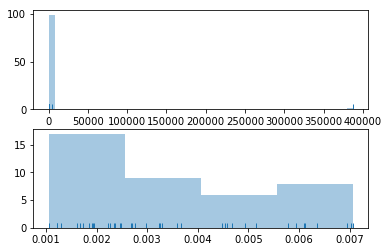

min_mse: 0.000929055386222899; min_rmse: 0.030480409876228683
 for hid=140, rad=1.2585127368965707,leak=0.9157855489439543


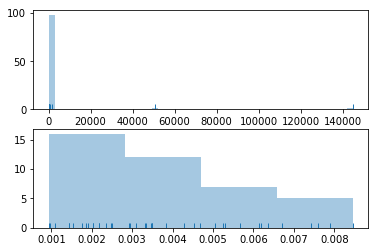

min_mse: 0.0006793920765630901; min_rmse: 0.02606515061462508
 for hid=131, rad=1.281689544106673,leak=0.8461313204795363


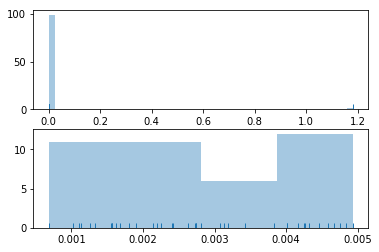

In [116]:

from echotorch.datasets.MackeyGlassDataset import MackeyGlassDataset
import echotorch.nn as etnn
import echotorch.utils
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader

# Dataset params
train_sample_length = 1000
n_train_samples = 2

for i in range(10):
    train = MackeyGlassDataset2(train_sample_length, n_train_samples, tau=17,delta=1,delay=6)
    trainloader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)
    trainiter = iter(trainloader)
    min_mse,min_rmse,min_hidden,min_radius,min_leaky,mses = random_grid_search_stacked(
        trainiter.next(),
        trainiter.next(),
        hidden_range=[100,180],
        radius_range=[1,1.6],
        leaky_range=[0.8,0.95],
        num_samples=100
        )
    print(f'min_mse: {min_mse}; min_rmse: {min_rmse}\n for hid={min_hidden}, rad={min_radius},leak={min_leaky}')
    fig, axs = plt.subplots(2)
    sns.distplot(mses,rug=True,kde=False,ax = axs[0])

    sns.distplot(sorted(mses)[:40],rug=True,kde=False,ax = axs[1])
    
    plt.show()

after introducing StackedESN  wee see slightly better improvement in best results (RMSE = 0.026) but far more better stability of ESN

Let's make some changes to dataset to be able to compare our results to ones obtained in this paper: https://dl.acm.org/doi/10.1145/3305160.3305187 

In [151]:
def R2(predicted_data,actual_data,horizon=0):
    predicted = predicted_data.numpy()[0,-horizon:,0]
    actual = actual_data.numpy()[0,-horizon:,0]
    avg = np.average(actual)
    div_up = predicted-actual
    div_down = actual-avg
    return 1 - np.sum((div_up*div_up))/np.sum((div_down*div_down))

In [160]:
import random

def random_grid_search_stacked_ahead(train_data,test_data,hidden_range,radius_range,leaky_range,num_samples,horizon=30):
    train_inputs,train_targets = train_data
    test_inputs,test_targets = test_data
    
    hidden = np.random.randint(hidden_range[0],hidden_range[1],size=num_samples,dtype=np.int32)
    radius = np.random.rand(num_samples)*(radius_range[1] -radius_range[0]) + radius_range[0]
    leaky = np.random.rand(num_samples)*(leaky_range[1] -leaky_range[0])+leaky_range[0]
    
    max_r2=None
    min_hidden,min_radius,min_leaky=None,None,None
    r2s = []
    
    for hid,rad,leak in zip(hidden,radius,leaky):
        esn = etnn.StackedESN(
            input_dim=1,
            hidden_dim=[int(hid),int(hid),int(hid),int(hid),int(hid)],
            output_dim=1,
            spectral_radius=rad,
            learning_algo='inv',
            leaky_rate=[leak,leak,leak,leak,leak]
        )
        esn(train_inputs, train_targets)
        esn.finalize()
        y_predicted = esn(test_inputs)
        r2 = R2(y_predicted.data,test_targets.data,horizon=horizon)
        if not max_r2 or r2 > max_r2:
            max_r2,min_hidden,min_radius,min_leaky=r2,hid,rad,leak
        r2s.append(r2)
    
    return max_r2,min_hidden,min_radius,min_leaky,r2s
        
        
    


In [159]:

from echotorch.datasets.MackeyGlassDataset import MackeyGlassDataset
import echotorch.nn as etnn
import echotorch.utils
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader

# Dataset params
train_sample_length = 2000
n_train_samples = 2
horizons=[30,50,70]

for h in horizons:
    for i in range(5):
        train = MackeyGlassDataset2(train_sample_length, n_train_samples, tau=17,delta=1,delay=h)
        trainloader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)
        trainiter = iter(trainloader)
        r2,min_hidden,min_radius,min_leaky,r2s = random_grid_search_stacked_ahead(
            trainiter.next(),
            trainiter.next(),
            hidden_range=[100,180],
            radius_range=[1,1.6],
            leaky_range=[0.8,0.95],
            num_samples=40,
            horizon=horizon
            )
        print(f'for horizon {h}: max_r2: {r2};\n for hid={min_hidden}, rad={min_radius},leak={min_leaky}\n')

for horizon 30: max_r2: 0.9874899731948972;
 for hid=137, rad=1.3928400491942041,leak=0.830258720651495

for horizon 30: max_r2: 0.9784480817615986;
 for hid=159, rad=1.1358879973552403,leak=0.8961113350988288

for horizon 30: max_r2: 0.9799442924559116;
 for hid=172, rad=1.2323077780373257,leak=0.930567736664905

for horizon 30: max_r2: 0.9786760564893484;
 for hid=112, rad=1.2387541181308548,leak=0.8623663667513457

for horizon 30: max_r2: 0.9788417592644691;
 for hid=151, rad=1.4280497976297601,leak=0.8141330705619356

for horizon 50: max_r2: 0.9688014965504408;
 for hid=174, rad=1.3321595612060495,leak=0.8890345128548656

for horizon 50: max_r2: 0.9687593318521976;
 for hid=147, rad=1.4421774277978114,leak=0.8358723604435666

for horizon 50: max_r2: 0.9693099148571491;
 for hid=158, rad=1.3515188011366193,leak=0.843691837003024

for horizon 50: max_r2: 0.972684133797884;
 for hid=158, rad=1.5089787288280414,leak=0.9158466608610604

for horizon 50: max_r2: 0.96779790148139;
 for hid

KeyboardInterrupt: 

When comparing to results from the paper above - stackedESN seems to be much more stable solution
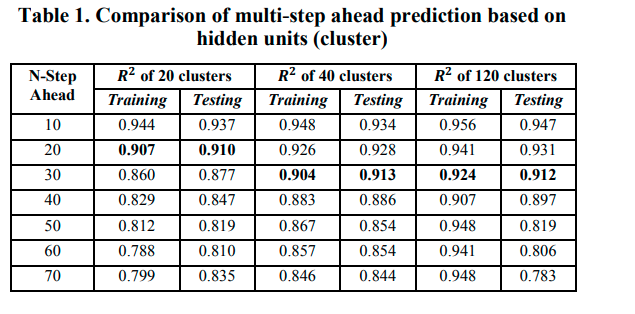

Our results decrease just a tiny bit comparing to theirs

Test R2: 0.939280342310667


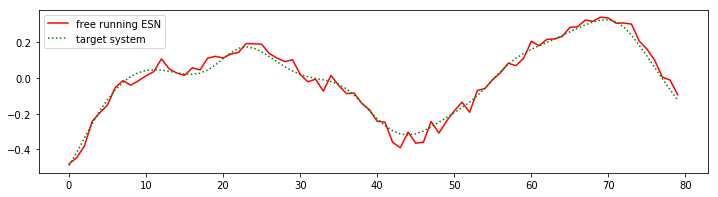

In [170]:
horizon =70
train = MackeyGlassDataset2(2000, 2, tau=17,delta=1,delay=horizon)
trainloader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)
esn = etnn.StackedESN(
    input_dim=1,
    hidden_dim=[154,154,154,154],
    output_dim=1,
    spectral_radius=1.246,
    learning_algo='inv',
    leaky_rate=[0.820,0.820,0.820,0.820]
)


dataiter = iter(trainloader)
data = dataiter.next()
#train
inputs, targets = data
esn(inputs, targets)
esn.finalize()

test_u, test_y = dataiter.next()
y_predicted = esn(test_u)
print(u"Test R2: {}".format(R2(y_predicted.data, test_y.data)))

plt.figure(figsize=(12,3))
plt.plot(range(horizon+10),list(y_predicted.data.reshape((-1,))[-(horizon+10):]),'r-', label="free running ESN")
plt.plot(range(horizon+10),list(test_y.data.reshape((-1,))[-(horizon+10):]),'g:',label="target system")
plt.legend()
plt.show()

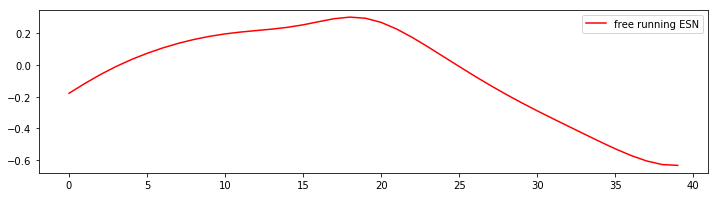

In [181]:
plt.figure(figsize=(12,3))
plt.plot(range(40),list(targets.data.reshape((-1,))[-20:]) + list(test_u.data.reshape((-1,))[:20]),'r-', label="free running ESN")
# plt.plot(range(19,39),list(test_u.data.reshape((-1,))[:20]),'g:',label="target system")
plt.legend()
plt.show()

Test R2: 0.9431039467453957


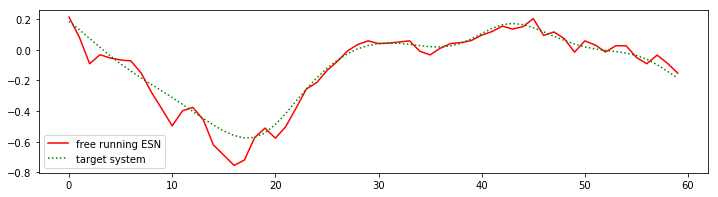

In [183]:

horizon =50
train = MackeyGlassDataset2(2000, 2, tau=17,delta=1,delay=horizon)
trainloader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)
esn = etnn.StackedESN(
    input_dim=1,
    hidden_dim=[154,154,154,154],
    output_dim=1,
    spectral_radius=1.246,
    learning_algo='inv',
    leaky_rate=[0.820,0.820,0.820,0.820]
)


dataiter = iter(trainloader)
data = dataiter.next()
#train
inputs, targets = data
esn(inputs, targets)
esn.finalize()

test_u, test_y = dataiter.next()
y_predicted = esn(test_u)
print(u"Test R2: {}".format(R2(y_predicted.data, test_y.data,horizon)))

plt.figure(figsize=(12,3))
plt.plot(range(horizon+10),list(y_predicted.data.reshape((-1,))[-(horizon+10):]),'r-', label="free running ESN")
plt.plot(range(horizon+10),list(test_y.data.reshape((-1,))[-(horizon+10):]),'g:',label="target system")
plt.legend()
plt.show()

In [186]:
inp = inputs
for i in range(3):
    inp = esn(inp)

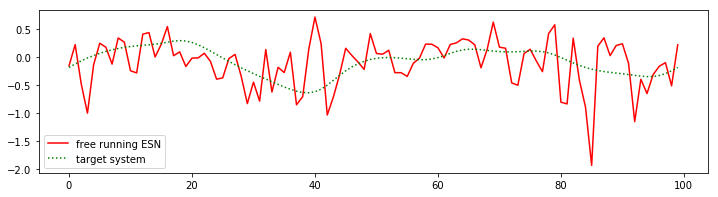

In [187]:
plt.figure(figsize=(12,3))
plt.plot(range(2*horizon),list(inp.data.reshape((-1,))[-(2*horizon):]),'r-', label="free running ESN")
plt.plot(range(2*horizon),list(test_u.data.reshape((-1,))[:2*horizon]),'g:',label="target system")
plt.legend()
plt.show()

<Figure size 864x216 with 0 Axes>

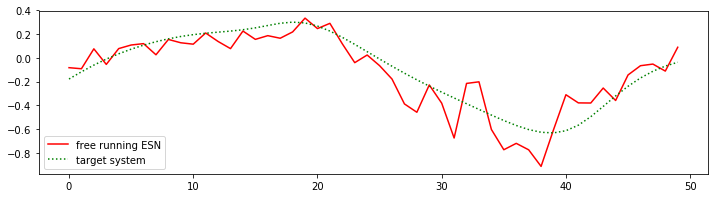

In [188]:
numho = 2
inp = inputs
for i in range(numho):
    inp = esn(inp)
    plt.figure(figsize=(12,3))
plt.plot(range((numho-1)*horizon),list(inp.data.reshape((-1,))[-((numho-1)*horizon):]),'r-', label="free running ESN")
plt.plot(range((numho-1)*horizon),list(test_u.data.reshape((-1,))[:(numho-1)*horizon]),'g:',label="target system")
plt.legend()
plt.show()

In [ ]:
*zrobić free running na horyzoncie 50 20 razy z rzędzu na train i porównac czy cokolwiek z tego wyszło
* zrobic lorenz attractor albo cos w ten desen